## Importing Liabraries 

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time
import copy

## Data Transformation

Transformations here refer to playing with images. Like, seriously the pytorch library is like: it seems like you don't have many images so what if I flip them around a bit to make it challenging for the model to overfit on this data? This way, it helps us get more images.

In [2]:
data_transforms = {
    
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(256),       # It crops the images to a square of 256 px a side.
        transforms.RandomHorizontalFlip(),       # It flips images horizontally.
        transforms.RandomAffine(90, scale = (1, 1.5)),  # RandomAffine rotates images to some certain degrees, it fills space with black gradient.
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [ .229, .224, .225]) # This normalizes the Tensors of the Images using ImageNets' presets.    
    ]),
    
    'val' : transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(90, scale = (1, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [ .229, .224, .225])
    ])
    
}

## Defining Directories

In [3]:
DataDir = 'Datasets/'

images = {x: datasets.ImageFolder(os.path.join(DataDir, x), data_transforms[x])
          for x in ['train', 'val']}

# This loads data for the model:
dataloaders = {x: torch.utils.data.DataLoader(images[x], batch_size = 4, shuffle = True, num_workers = 4)
               for x in ['train', 'val']}

# These are the number of images in both, training and validation sets:
dataset_sizes = {x: len(images[x]) for x in ['train', 'val']}

# These refer to the categories in the data:
class_names = images['train'].classes

## Visualizing:
Okay, so we have to define a function which predicts on new images that the model has not seen after it is done training on the given data, lets make that and lets visualize what we have here in the data too.

In [4]:
# Defining a function to visualize the model:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finally lets end the suffering and take a look at the images, a bit of angry text there but bear with me:

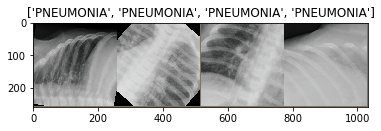

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))


out = torchvision.utils.make_grid(inputs)


imshow(out, title = [class_names[x]  for x in classes])

## Training the Model:

Finally we are training the model!

In [6]:
# def a function for the latter:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
# Getting our beloved CUDA:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Using transfer learning or using a pretrained ResNet50, same thing.
model_ft = models.resnet50(pretrained=True)

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

# Handing the model to our Device:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
#TRAINING THE MODEL FINALLY:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs = 30)

Epoch 0/29
----------
train Loss: 0.4249 Acc: 0.8138
val Loss: 1.6915 Acc: 0.6250

Epoch 1/29
----------
train Loss: 0.3818 Acc: 0.8474
val Loss: 0.9506 Acc: 0.5625

Epoch 2/29
----------
train Loss: 0.3167 Acc: 0.8733
val Loss: 3.2089 Acc: 0.6250

Epoch 3/29
----------
train Loss: 0.2927 Acc: 0.8878
val Loss: 3.0293 Acc: 0.6250

Epoch 4/29
----------
train Loss: 0.2711 Acc: 0.8978
val Loss: 2.3591 Acc: 0.5625

Epoch 5/29
----------
train Loss: 0.2580 Acc: 0.9026
val Loss: 1.7381 Acc: 0.5625

Epoch 6/29
----------
train Loss: 0.2537 Acc: 0.9024
val Loss: 2.3360 Acc: 0.6250

Epoch 7/29
----------
train Loss: 0.2027 Acc: 0.9225
val Loss: 0.9233 Acc: 0.6250

Epoch 8/29
----------
train Loss: 0.1878 Acc: 0.9293
val Loss: 1.1392 Acc: 0.5625

Epoch 9/29
----------
train Loss: 0.1780 Acc: 0.9329
val Loss: 0.9160 Acc: 0.6250

Epoch 10/29
----------
train Loss: 0.1770 Acc: 0.9344
val Loss: 0.8569 Acc: 0.6875

Epoch 11/29
----------
train Loss: 0.1658 Acc: 0.9369
val Loss: 1.2657 Acc: 0.6250

Ep

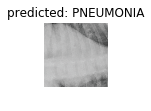

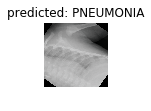

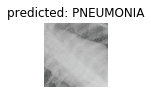

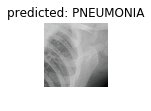

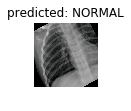

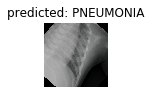

In [13]:
visualize_model(model_ft)